<a href="https://colab.research.google.com/github/AshkanGanj/Pneumonia-Detection-X-Ray-CNN/blob/main/X_Ray_Pneumonia_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'ashkanganj' # enter your kaggle username
os.environ['KAGGLE_KEY'] = 'e946c73e99b8fcb29f974e0a72a2207d' # enter your kaggle key
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:27<00:00, 49.8MB/s]
100% 2.29G/2.29G [00:27<00:00, 88.9MB/s]


**Unzip downloaded file**

In [ ]:
%%capture
!unzip chest-xray-pneumonia.zip

### **Import all required packages**

In [30]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


sns.set_theme(style="whitegrid", palette="deep")

### load data

Load all 3 groups, which are train, validation, and test.

In [49]:
path = '/content/chest_xray/chest_xray/'

!ls /content
# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

chest_xray  sample_data


### Data Visualization & Preprocessing

draw figures to get a good understanding of our data situation

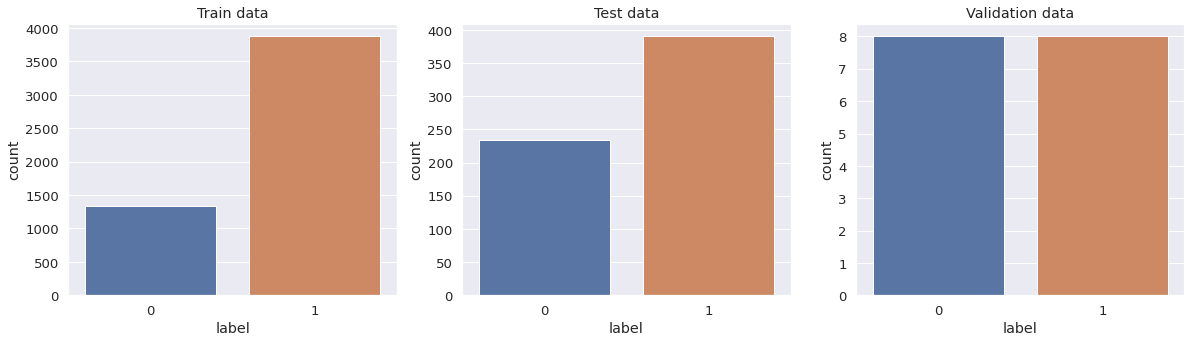

In [50]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()



As we can see our test and train Data is imbalanced. 
To fix this problem, we should increase our dataset size with the help of data augmentation.

### Previewing some sample images

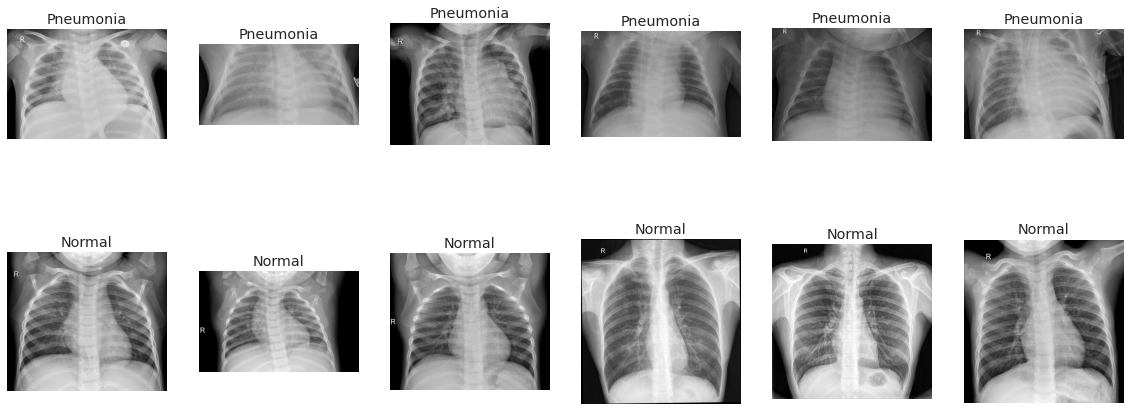

In [51]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:6]['image']):
    plt.subplot(2,6,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:6]['image']):
    plt.subplot(2,6,6+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

### Preprocessing data
we have to step


*   load image, resize it, convert to grayscale, normalize and reshape to dimension required for tensorflow
*   loop through images, generating 2 numpy arrays. First contains image itself as matrix, second contains label



In [52]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [53]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))



Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


### Image augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. 

In [54]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)



In [55]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

### create our model
Simple sequential model is used, starting with 2 convolutional networks of kernel size (7,7) and max pooling with pool size (3,3), followed by 2 convolutional networks of kernel size (7,7) and same pool size and finalized by several repeating sets of 2 convolutional networks of kernel size (3,3) with max pooling and pool size (2,2)

Model bit slower, but getting above 92% accuracy that's great result!


In [56]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 196, 196, 8)       400       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 196, 196, 8)       3144      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 65, 65, 8)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 65, 65, 16)        3216      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 65, 65, 16)        6416      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 21, 21, 32)       

### Fit model
Here i going to set number of epochs to 20 but for getting a better result you can set it to 50 or 124

In [57]:
callback = EarlyStopping(monitor='loss', patience=6)
history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 20, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})


Epoch 1/20
1304/1304 [==============================] - 34s 25ms/step - loss: 0.6335 - accuracy: 0.5690 - val_loss: 0.6465 - val_accuracy: 0.6811
Epoch 2/20
1304/1304 [==============================] - 32s 24ms/step - loss: 0.3703 - accuracy: 0.8054 - val_loss: 0.6217 - val_accuracy: 0.7548
Epoch 3/20
1304/1304 [==============================] - 32s 24ms/step - loss: 0.3443 - accuracy: 0.8236 - val_loss: 0.5512 - val_accuracy: 0.7740
Epoch 4/20
1304/1304 [==============================] - 32s 24ms/step - loss: 0.3068 - accuracy: 0.8447 - val_loss: 0.3262 - val_accuracy: 0.8894
Epoch 5/20
1304/1304 [==============================] - 32s 24ms/step - loss: 0.2958 - accuracy: 0.8553 - val_loss: 0.3525 - val_accuracy: 0.8574
Epoch 6/20
1304/1304 [==============================] - 32s 24ms/step - loss: 0.2569 - accuracy: 0.8719 - val_loss: 0.3272 - val_accuracy: 0.8718
Epoch 7/20
1304/1304 [==============================] - 32s 24ms/step - loss: 0.2344 - accuracy: 0.8844 - val_loss: 0.3277 -

### Check our results
plot loss and accuarcy plots

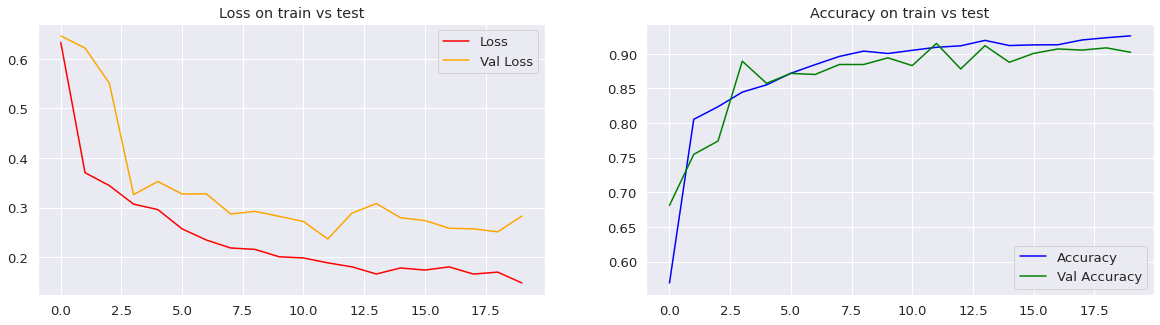

In [58]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

###confusion matrix

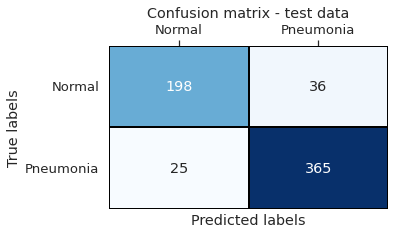

Classification report on test data
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       234
           1       0.91      0.94      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



In [59]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)


# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)



### Validating Data

In [60]:
y_val_hat = model.predict(X_val, batch_size=4)
y_val_hat = np.argmax(y_val_hat, axis=1)
y_val = np.argmax(y_val, axis=1)

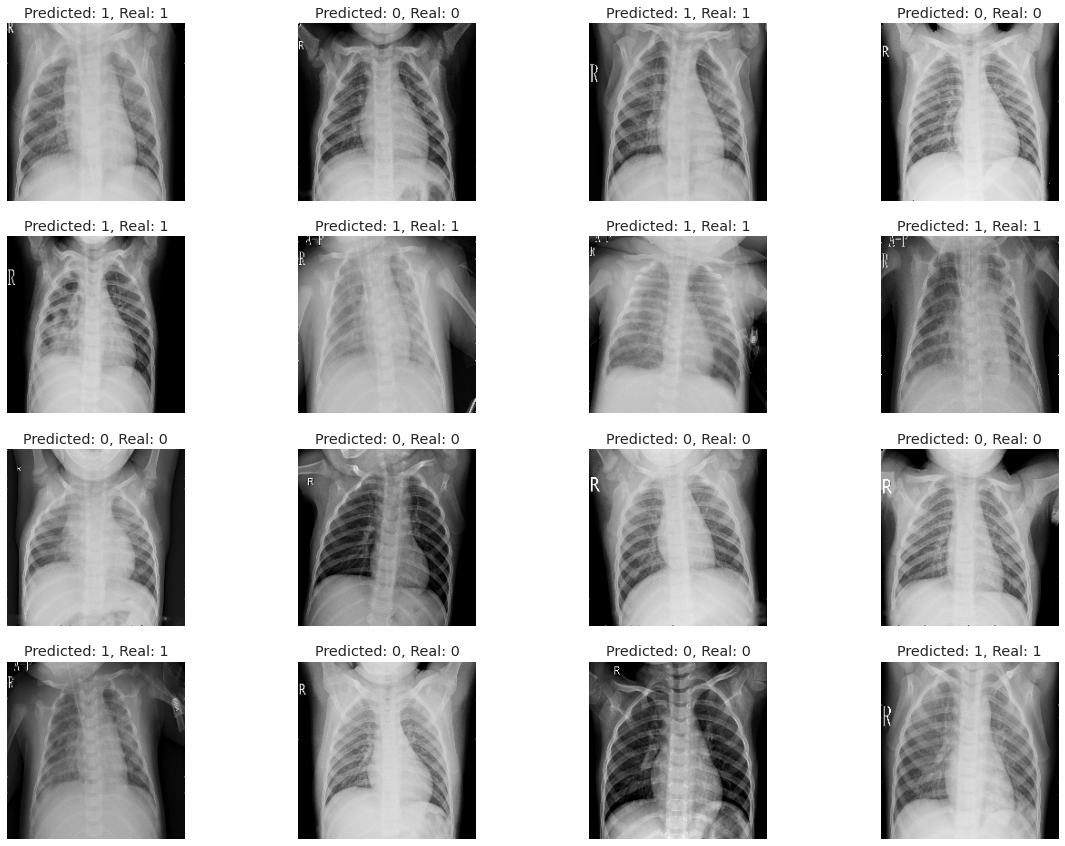

In [61]:
plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(196, 196), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]))  